In [1]:
import numpy as np
import pandas as pd
import constants as cons
import utils_data as ud
import utils_info as info
import utils_matrixes as um
import matplotlib.pyplot as plt
from openpyxl import workbook 
from openpyxl import load_workbook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# import warnings
# warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)


'''

Settings

'''

target_name = cons.TIMESERIES_TARGET_NAME
residual_target_name = cons.RESIDUAL_TARGET_NAME
temperature_name = cons.TEMPERATURE_NAME
source_folder = cons.SOURCE_FILES_FOLDER
calendar_folder = cons.CALENDAR_FOLDER
forecast_folder = cons.FORECAST_FILE_FOLDER
model_folder = cons.MODEL_FOLDER
benchmark_folder = cons.BENCHMARK_FOLDER
log_folder = cons.LOGS_FOLDER
horison = cons.FORECAST_HORISON
test_results_folder = cons.personal_data_folder

company = 'Company'
hub = 'HUB1'                
test_filename = 'test_results.xlsx'

fcst_date = pd.datetime(2019, 9, 22)
min_lag = None                             # if None will be defined automatically
check_range_start = pd.datetime(2019, 9, 1)


'''

Main

'''


dates_range = pd.date_range(check_range_start - pd.Timedelta(70, unit='D'),
                            fcst_date + pd.Timedelta(23, unit='H'), freq='H')
#print('DR', dates_range)
fcst_range = pd.date_range(fcst_date, fcst_date + pd.Timedelta(23, unit='H'), freq='H')
#print('FR', fcst_range)
model_info = info.get_model_info(company, hub)

source_data = ud.get_data(model_info['actuals_filename'], dates_range[0], dates_range[-1],
                          model_info['actuals_dateformat'])
dates_actual_range = pd.date_range(source_data.index.values[0], source_data.index.values[-1], freq='H')  
#print('DAR', dates_range)

if min_lag is None:
    c = np.ones(len(dates_range)) * -1
    data = pd.DataFrame(c, index=dates_range, columns=[target_name])
    mask = data.index.isin(dates_actual_range)
    data[mask] = source_data
    mask = data[target_name] == -1
    min_lag = sum(mask)
    source_data = data

print('min lag = %d' % min_lag)

'''

Regress model forecast

'''

model_settings_regress = ud.load_model_settings(company, hub, min_lag, 'regress')
regress_data, regress_pred_name = um.make_regress_forecast(source_data.copy(), model_settings_regress,
                                                           model_info, dates_range[0], dates_range[-1])

print('Regress forecast is done')

'''

Network model forecast

'''

model_settings_network = ud.load_model_settings(company, hub, min_lag, 'network')
network_data, network_pred_name = um.make_network_forecast(source_data.copy(), model_settings_network,
                                                           model_info, dates_range[0], dates_range[-1])

print('Network forecast is done')

'''

XGBoost model forecast

'''

model_settings_xgboost = ud.load_model_settings(company, hub, min_lag, 'xgboost')
xgboost_data, xgboost_pred_name = um.make_xgboost_forecast(source_data.copy(), model_settings_xgboost,
                                                           model_info, dates_range[0], dates_range[-1])

print('Xboost forecast is done')
'''

Consensus

'''

dates_range = pd.date_range(check_range_start, fcst_date + pd.Timedelta(23, unit='H'), freq='H')
mask_network = dates_range.isin(network_data.index)
mask_regress = dates_range.isin(regress_data.index)

if sum(mask_network) < sum(mask_regress):
    dates_range_new = dates_range[mask_network]
else:
    dates_range_new = dates_range[mask_regress]


regress_data = regress_data.loc[dates_range_new, :]
network_data = network_data.loc[dates_range_new, :]

consensus = pd.DataFrame(np.zeros(len(dates_range_new)), index=dates_range_new, columns=['prediction'])
consensus['prediction'] = (network_data[network_pred_name] + regress_data[regress_pred_name]) / 2
consensus[cons.TIMESERIES_TARGET_NAME] = network_data[cons.TIMESERIES_TARGET_NAME]

nd = network_data[cons.TIMESERIES_TARGET_NAME] > 0
dates_compare_range = nd[nd.values].index

print('Regress, prediсtion name = ' + regress_pred_name + ':')
ud.get_accuracy(regress_data.loc[dates_compare_range, cons.TIMESERIES_TARGET_NAME].values,
                regress_data.loc[dates_compare_range, regress_pred_name].values)
print('Network, predition name = ' + network_pred_name + ':')
ud.get_accuracy(network_data.loc[dates_compare_range, cons.TIMESERIES_TARGET_NAME].values,
                network_data.loc[dates_compare_range, network_pred_name].values)
print('Network, predition name = prediction:')
ud.get_accuracy(network_data.loc[dates_compare_range, cons.TIMESERIES_TARGET_NAME].values,
                network_data.loc[dates_compare_range, 'prediction'].values)
print('Consensus over %s and %s:' % (regress_pred_name, network_pred_name))
ud.get_accuracy(consensus.loc[dates_compare_range, cons.TIMESERIES_TARGET_NAME].values,
                consensus.loc[dates_compare_range, 'prediction'].values)
print('XGBoost, predition name = ' + xgboost_pred_name + ':')
ud.get_accuracy(xgboost_data.loc[dates_compare_range, cons.TIMESERIES_TARGET_NAME].values,
                xgboost_data.loc[dates_compare_range, xgboost_pred_name].values)


min lag = 96
Model settings are uploaded from /home/jane/PowerConsumptionForecast/Models/AtomEnergoSbyt_PKURSKEN/AtomEnergoSbyt_PKURSKEN_regress_lags_96_model_settings.pickle
Regress forecast is done


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model settings are uploaded from /home/jane/PowerConsumptionForecast/Models/AtomEnergoSbyt_PKURSKEN/AtomEnergoSbyt_PKURSKEN_network_lags_96_model_settings.pickle
Source data is ready
Target:  residual
Predictors (65):  Index(['temperature', 'holidays', 'holidays_bunch', 'holidays_number_in_bunch',
       'holidays_always', 'sin_1', 'sin_2', 'sin_3', 'sin_4', 'sin_5', 'sin_6',
       'sin_7', 'weekly', 'monthly', 'trend', 'hourly_0', 'hourly_1',
       'hourly_2', 'hourly_3', 'hourly_4', 'hourly_5', 'hourly_6', 'hourly_7',
       'hourly_8', 'hourly_9', 'hourly_10', 'hourly_11', 'hourly_12',
       'hourly_13', 'hourly_14', 'hourly_15', 'hourly_16', 'hourly_17',
       'hourly_18', 'hourly_19', 'hourly_20', 'hourly_21', 'hourly_22',
       'hourly_23', 'daily_0', 'daily_1', 'daily_2', 'daily_3', 'daily_4',
       'daily_5', 'daily_6', 'sun_profile', 'consumption_lag_96

(7.1215802958791095, 2.349513679235855, 7.38736763045571, 8.101851851851851)

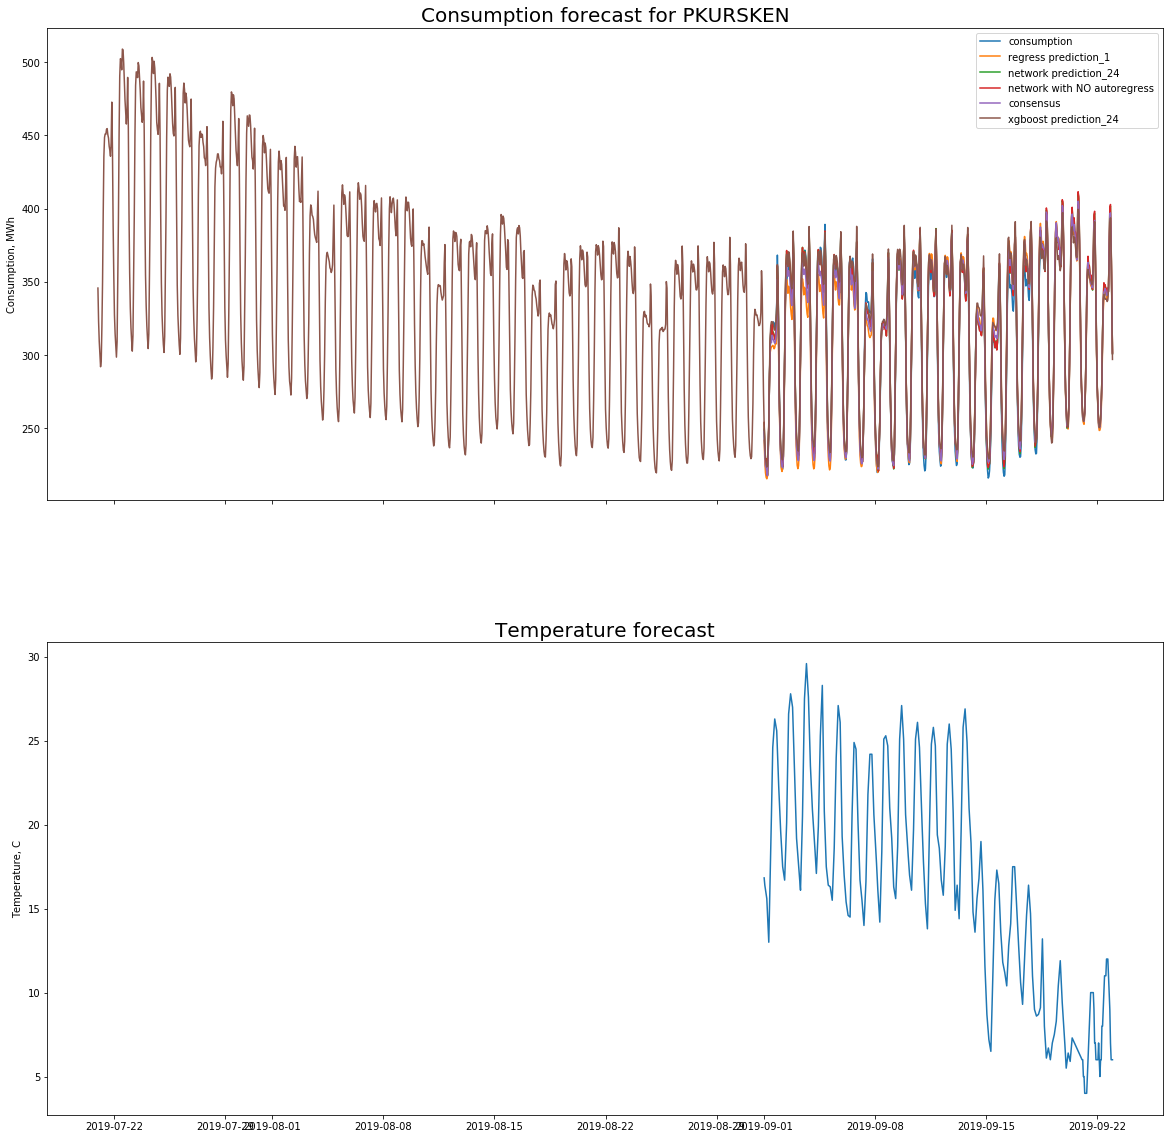

In [2]:
'''

Plot

'''

plot_data = regress_data[regress_data[cons.TIMESERIES_TARGET_NAME] != -1]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 20), sharex=True)
ax1.plot(plot_data.index, plot_data[cons.TIMESERIES_TARGET_NAME].values, label=cons.TIMESERIES_TARGET_NAME)
ax1.plot(regress_data.index, regress_data[regress_pred_name].values, label='regress ' + regress_pred_name)
ax1.plot(network_data.index, network_data[network_pred_name].values, label='network ' + network_pred_name)
ax1.plot(network_data.index, network_data['prediction'].values, label='network with NO autoregress')
ax1.plot(consensus.index, consensus['prediction'].values, label='consensus')
ax1.plot(xgboost_data.index, xgboost_data[xgboost_pred_name].values, label='xgboost ' + xgboost_pred_name)

ax1.set_title('Consumption forecast for ' + hub, fontsize=20)
ax1.set_ylabel('Consumption, MWh')
ax1.legend()
ax2.plot(regress_data.index, regress_data[cons.TEMPERATURE_NAME].values)
ax2.set_title('Temperature forecast', fontsize=20)
ax2.set_ylabel('Temperature, C')
plt.subplots_adjust(hspace=0.3)
plt.show()



In [3]:
try:
    d = {'consensus': consensus.loc[fcst_range, 'prediction'].values, 
         'network': network_data.loc[fcst_range, 'prediction'].values, 
         'network+AR': network_data.loc[fcst_range, 'prediction_24'].values, 
         'regress': regress_data.loc[fcst_range, 'prediction_1'].values,
         'xgboost': xgboost_data.loc[fcst_range, 'prediction_24'].values
        }
    all_forecasts = pd.DataFrame(data = d, index = fcst_range)
    
    wb = load_workbook(test_results_folder + test_filename)
    sheets = wb.sheetnames
    models = ['consensus', 'network', 'network+AR', 'regress', 'xgboost']
    models_cols = [6, 9, 12, 15, 18]
    
    for i, s in enumerate(sheets):
        if s == hub:
            sheet = wb[sheets[i]]
            first_empty_row = sheet.max_row + 1
            
    for j in range(horison):
        for c, m in  zip(models_cols, models):
            sheet.cell(row = first_empty_row + j, column = c).value = round(all_forecasts[m].values[j], 2)
            sheet.cell(row = first_empty_row + j, column = 18).value = min_lag
            
    wb.save(test_results_folder + test_filename)
    print('File  %s  is updated' % test_filename)

except NameError:
    pass

File  AES_test_results.xlsx  is updated


In [4]:
all_forecasts

,consensus,network,network+AR,regress,xgboost
2019-09-22 00:00:00,277.763517,278.120805,277.108291,278.418742,277.584490
2019-09-22 01:00:00,262.993679,265.099213,264.121532,261.865826,263.057924
2019-09-22 02:00:00,252.268075,253.611950,253.040564,251.495586,255.341625
2019-09-22 03:00:00,250.592235,253.679878,252.713979,248.470492,250.551879
2019-09-22 04:00:00,250.484500,253.505957,252.265922,248.703078,251.307646
2019-09-22 05:00:00,253.856742,257.958978,256.904896,250.808588,255.910992
2019-09-22 06:00:00,264.833151,268.290715,267.677288,261.989014,267.166206
2019-09-22 07:00:00,280.233068,283.600081,282.824877,277.641258,283.234120
2019-09-22 08:00:00,311.136773,315.567946,314.677958,307.595589,314.105748
2019-09-22 09:00:00,333.026085,337.610546,336.389025,329.663145,336.886658


In [1]:
print('Enter model name (network, regress, consensus):')
model = input()
print('Enter prediction name (%s, %s, prediction):' % (regress_pred_name, network_pred_name))
prediction_name = input()        # one from predictions

if model in ['network', 'regress', 'consensus']:

    if prediction_name in [regress_pred_name, network_pred_name, 'prediction']:

        filename = model_info['forecast_filename']
        filename = filename.replace('YYYY-MM-DD', fcst_date.strftime(cons.DATE_FORMAT))
        filename = filename.replace('type', model + '_' + prediction_name + '_' + str(min_lag))
        if model == 'network':
            forecast = pd.DataFrame(network_data.loc[fcst_range, prediction_name].values,
                                    columns=[cons.TIMESERIES_TARGET_NAME], index=fcst_range)
        elif model == 'regress':
            forecast = pd.DataFrame(regress_data.loc[fcst_range, prediction_name].values,
                                    columns=[cons.TIMESERIES_TARGET_NAME], index=fcst_range)
        elif model == 'consensus':
            forecast = pd.DataFrame(consensus.loc[fcst_range, prediction_name].values,
                                    columns=[cons.TIMESERIES_TARGET_NAME], index=fcst_range)

        forecast.index.name = cons.TIMESTEP_NAME
        forecast.to_csv(filename, date_format=cons.DATE_HOUR_FORMAT)

        print('Hub = ' + hub + ', lag = ' + str(min_lag) + ', model = ' + model + ', prediction = ' + prediction_name)
        print('Forecast is written to file %s' % filename)

    else:

        print('Model name or prediction name is incorrect, please check!')
